# University College London

**COMP0123 Complex Networks and Webs (2023/24)**

**Coursework 2**

HSCP7

January 2024

In [1]:
import os
import time
from datetime import datetime
import pickle

import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.stats import mode

import torch
from torchvision.transforms import v2
from torchvision.datasets import MNIST
from torchvision.models import efficientnet_b0

import networkx as nx
from networkx.algorithms.community import louvain_communities

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances

In [2]:
# Plot settings

sns.set_style('white')
sns.set_context("paper", font_scale = 2)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['figure.autolayout'] = False

In [3]:
# Use gpu if available

if torch.backends.mps.is_available():  # Apple Silicon
    DEVICE = "mps"
elif torch.cuda.is_available():  # Cuda GPU
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

In [4]:
# Set all random seed for reproducible results
def set_seed(seed=9999):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(9999)

In [5]:
# Storage Directories
DATA_PATH = './data'
FIG_PATH = './figures'

for path in [DATA_PATH, FIG_PATH]:
    if not os.path.isdir(path):  # create if not exist
        os.mkdir(path)

# The MNIST Dataset

In [6]:
def balance_class_dataset(dataset, n_data, n_class):
    """Create a subset from @dataset such the number of data in
    each class is balanced
    """
    assert len(dataset) > n_data

    all_indices = np.arange(len(dataset))
    np.random.shuffle(all_indices)

    subset_indices = []
    bins_count = np.zeros(n_class)
    bins_max = np.ones(n_class) * (n_data//n_class)
    bins_max[:(n_data%n_class)] += 1

    for idx in all_indices:
        _, label = dataset[idx]
        if bins_count[label] < bins_max[label]:
            subset_indices.append(idx)
            if len(subset_indices) == n_data:  # Stop when added enough data
                break

    subset_indices = np.array(subset_indices)
    np.random.shuffle(subset_indices)

    return (dataset.data[subset_indices].to(torch.float32),
            dataset.targets[subset_indices])


# Download and load the MNIST data
train_set = MNIST(root=DATA_PATH, train=True, download=True)
test_set = MNIST(root=DATA_PATH, train=False, download=True)

N_TRAIN, N_TEST = 2000, 500
N_CLASS = len(train_set.classes)
CLASSES = set(range(N_CLASS))
train_X, train_Y = balance_class_dataset(train_set, N_TRAIN, N_CLASS)
test_X, test_Y = balance_class_dataset(test_set, N_TEST, N_CLASS)
train_raw, test_raw = train_X.flatten(1).numpy(), test_X.flatten(1).numpy()
Y = np.concatenate([train_Y, test_Y])

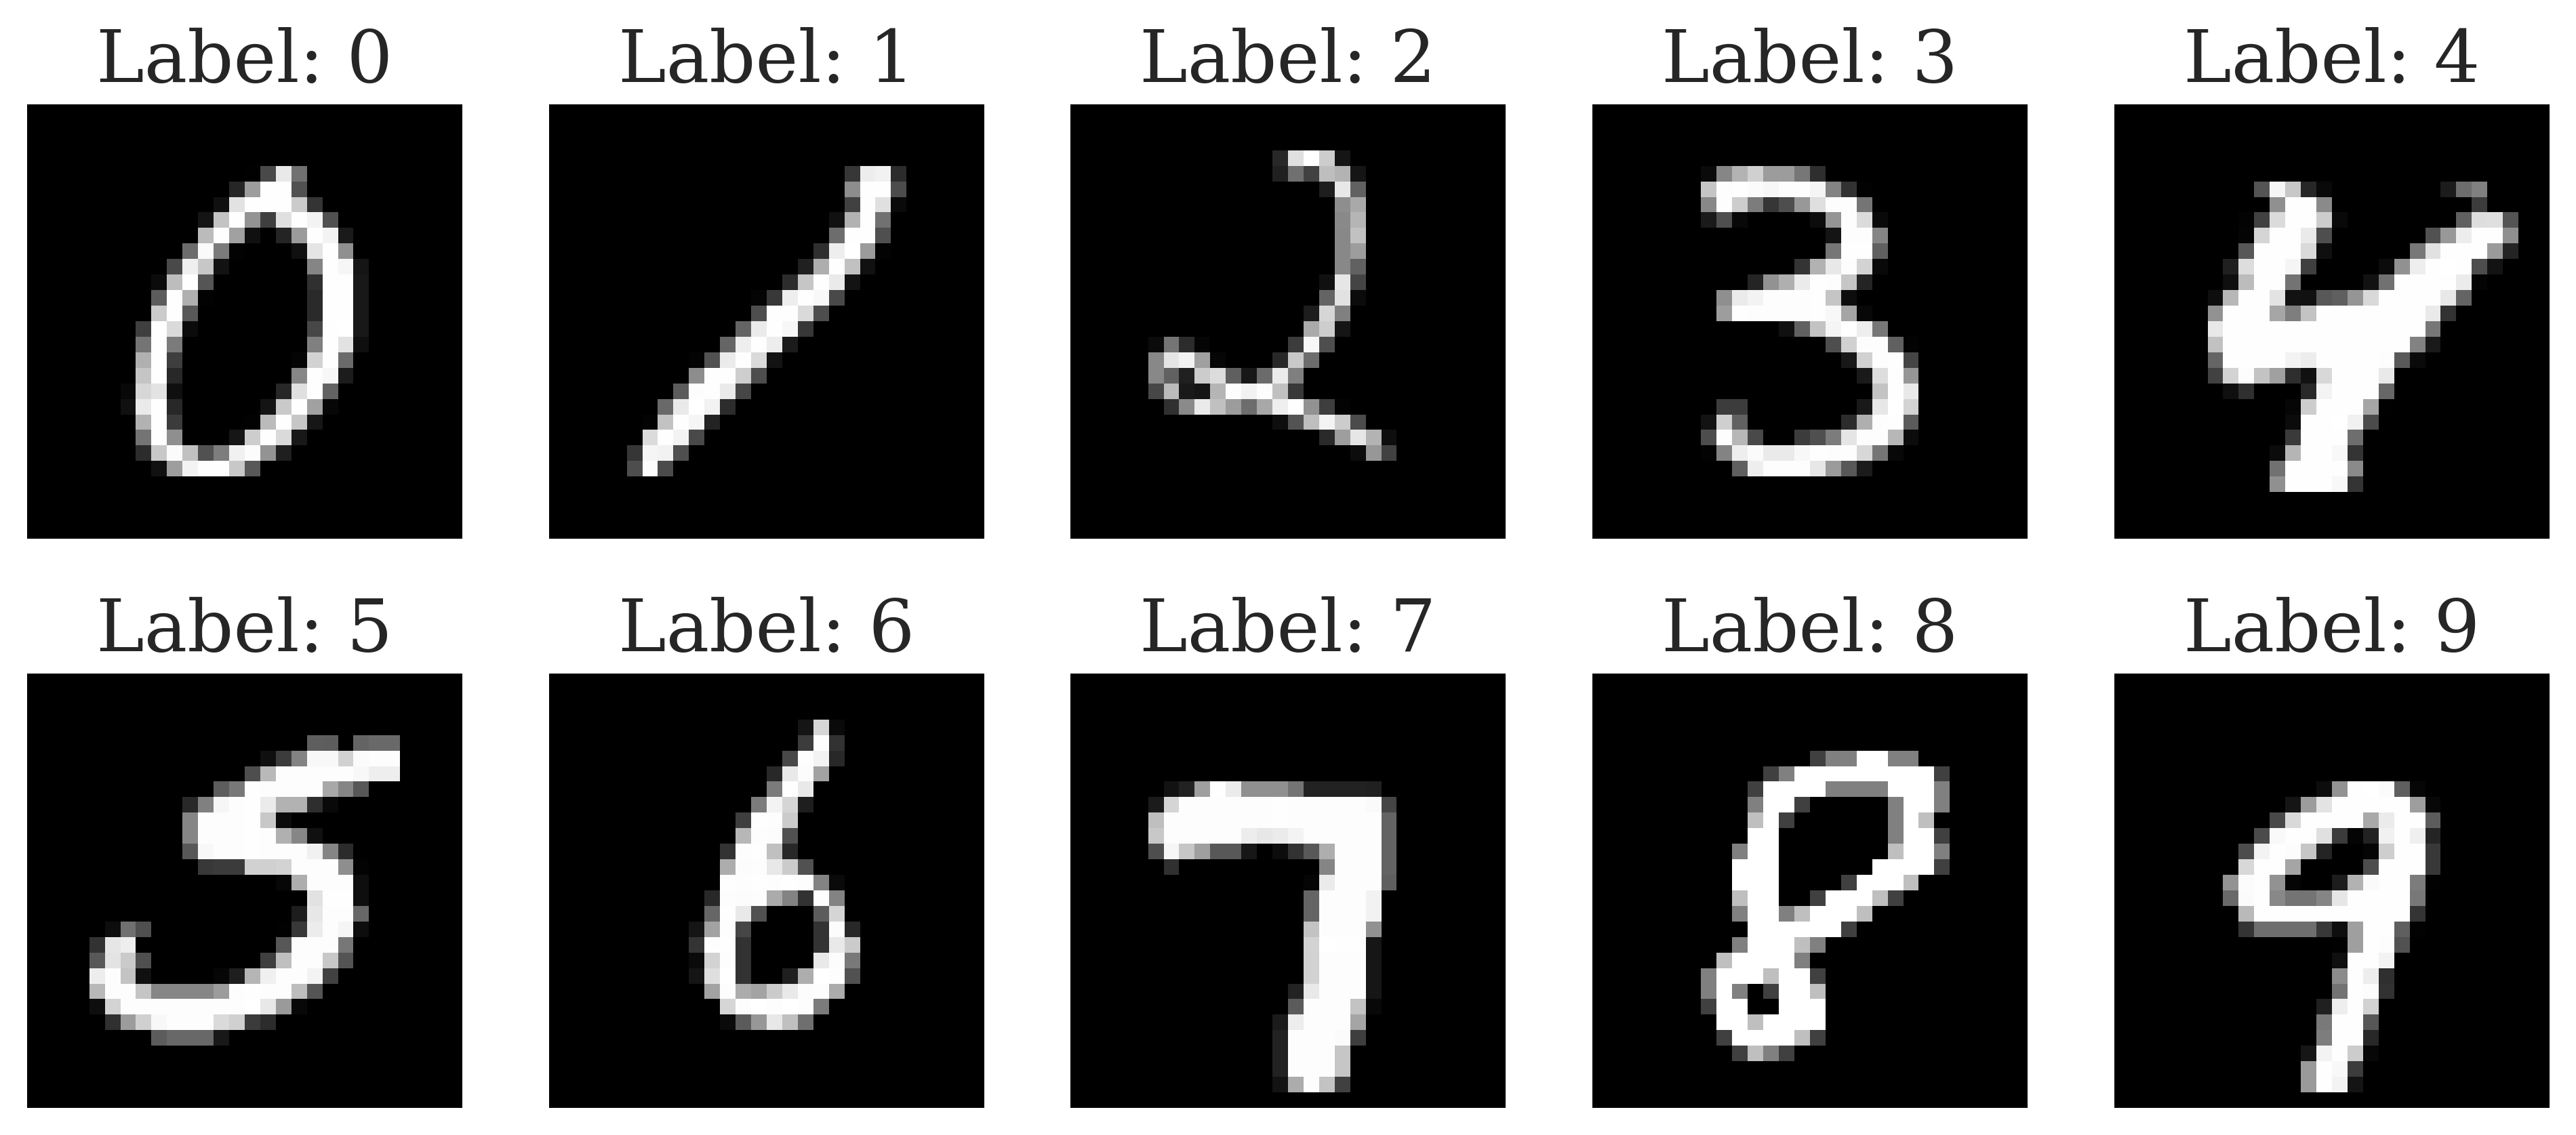

In [7]:
# Plot the first image from each class
fig, ax = plt.subplots(2, 5)
fig.set_size_inches(12, 5)
fig.set_dpi(400)
for digit in range(10):
    first_image = np.where(train_Y == digit)[0][0]
    ax[digit//5][digit%5].imshow(train_X[first_image], cmap='gray')
    ax[digit//5][digit%5].set_title(f'Label: {digit}')
    ax[digit//5][digit%5].axis('off')
fig.savefig(os.path.join(FIG_PATH, 'first_image_of_each_class.pdf'))

# EfficientNet Encoder

## Data Loader for MNIST

In [8]:
def yield_batches(data, targets=None, batch_size=16, transform=None, start=0):
    n_data = len(data)

    if targets is not None:
        assert n_data == len(targets)

    if transform is not None:
        data = transform(data)

    while start < n_data:
        end = start + batch_size
        if targets is not None:
            yield data[start:end], targets[start:end]
        else:
            yield data[start:end]
        start = end


def mnist_effnet_dataloader(train=True):
    if train:
        return yield_batches(train_X, train_Y, transform=effnet_transform)
    else:
        return yield_batches(test_X, test_Y, transform=effnet_transform)


## Data transform for MNIST
train_mean = train_X.mean()
train_std = train_X.std()

effnet_transform = v2.Compose([
    v2.ToDtype(torch.float32),
    v2.Normalize((train_mean,), (train_std,)),  # Standardisation
    v2.Lambda(lambda x: x.unsqueeze(1).repeat(1, 3, 1, 1))
])

## Pretrained Model and Training

In [9]:
effnet_clf = efficientnet_b0(weights='IMAGENET1K_V1')  # Pretrained weights

# Change the last classification layers for our dataset no. of classes
latent_dim = effnet_clf.classifier[1].in_features
effnet_clf.classifier[1] = torch.nn.Linear(latent_dim, N_CLASS)
effnet_clf.to(DEVICE)
effnet_clf.train()

cross_loss = torch.nn.CrossEntropyLoss()
adam_opt = torch.optim.Adam(effnet_clf.parameters(), lr=0.001)


def training(get_dataloader, model, loss_func, opt, epochs=10):
    for epoch in range(epochs):
        start = time.time()
        epoch_loss = 0.0
        dataloader = get_dataloader()
        for data, targets in dataloader:
            # Reset grads for recompute
            opt.zero_grad()
            # Forward
            outputs = model(data.to(DEVICE))
            loss = loss_func(outputs, targets.to(DEVICE))
            # Backward and optimize
            loss.backward()
            opt.step()
            epoch_loss += loss.item()

        print(f'Epoch [{epoch+1}/{epochs}] in {time.time()-start:.2f} sec: '
              f'loss = {epoch_loss/len(train_X):.4f}')

    print('Finished Training')

In [10]:
# Training forward for 10 epochs for the model to learn MNIST features
training(mnist_effnet_dataloader, effnet_clf, cross_loss, adam_opt, epochs=10)

Epoch [1/10] in 20.86 sec: loss = 0.0737
Epoch [2/10] in 17.87 sec: loss = 0.0429
Epoch [3/10] in 17.82 sec: loss = 0.0295
Epoch [4/10] in 18.22 sec: loss = 0.0194
Epoch [5/10] in 18.55 sec: loss = 0.0155
Epoch [6/10] in 18.56 sec: loss = 0.0120
Epoch [7/10] in 17.45 sec: loss = 0.0146
Epoch [8/10] in 18.19 sec: loss = 0.0142
Epoch [9/10] in 18.61 sec: loss = 0.0107
Epoch [10/10] in 18.55 sec: loss = 0.0064
Finished Training


## Performance of EfficientNet

In [11]:
effnet_clf.eval()
torch.save(effnet_clf, os.path.join(DATA_PATH, 'efficientnet_classifier.pkl'))

with torch.no_grad():
    prob_Y = effnet_clf(effnet_transform(test_X).to(DEVICE)).cpu()
pred_Y = torch.argmax(prob_Y, dim=1)
print('-'*50 + '\nEfficientNet Performance\n' + '-'*50)
print(f'test score: {(pred_Y == test_Y).sum().item() / len(test_Y)}')

--------------------------------------------------
EfficientNet Performance
--------------------------------------------------
test score: 0.966


## Encoder

In [12]:
# Encoder for MNIST, drop the classification layer
effnet_enc = effnet_clf.features
effnet_enc.eval()

torch.save(effnet_enc, os.path.join(DATA_PATH, 'efficientnet_encoder.pkl'))

# Function to extract features for a batch of images
def encode(dataloader, encoder):
    with torch.no_grad():
        encoded_batches = [encoder(data.to(DEVICE)).cpu().numpy()
                           for data, _ in dataloader]
    return np.concatenate(encoded_batches).squeeze()


# Extract features from the train loader
train_latent = encode(mnist_effnet_dataloader(train=True), effnet_enc)
test_latent = encode(mnist_effnet_dataloader(train=False), effnet_enc)
assert len(train_latent) == len(train_X)
assert len(test_latent) == len(test_X)
assert train_latent.shape[1] == test_latent.shape[1]
print(f'Embedding dimensions: {test_latent.shape[1]}')

Embedding dimensions: 1280


In [13]:
# Store all features
with open(os.path.join(DATA_PATH, 'feature_vectors_raw.pkl'), 'wb+') as f:
    pickle.dump((train_raw, test_raw), f)
with open(os.path.join(DATA_PATH, 'feature_vectors_latent.pkl'), 'wb+') as f:
    pickle.dump((train_latent, test_latent), f)
with open(os.path.join(DATA_PATH, 'labels.pkl'), 'wb+') as f:
    pickle.dump((train_Y.numpy(), test_Y.numpy()), f)

# Performance of Supervised Learning

## K Nearest Neighbour Grid Search

In [14]:
def kNN_GridSearch(train_feat, train_Y):
    param_grid = {'n_neighbors': list(range(1, 50)),
                  'weights': ('uniform', 'distance'),
                  'metric': ('cosine', 'l2'),
                  }
    kNN = KNeighborsClassifier()
    clf = GridSearchCV(kNN, param_grid, n_jobs=-1)
    clf.fit(train_feat, train_Y)
    return clf

def gridsearch_resutls(clf, test_feat, test_Y, filename):
    print(f'best params: {clf.best_params_}')
    print(f'mean valid score: {clf.cv_results_["mean_test_score"].max()}')
    print(f'test score : {clf.score(test_feat, test_Y)}')
    pd.DataFrame(clf.cv_results_).to_csv(filename, index=False)


print('-'*50 + '\nUsing Raw Features\n' + '-'*50)
raw_knn_clf = kNN_GridSearch(train_raw, train_Y)
filename = os.path.join(DATA_PATH, 'knn_raw_cv.csv')
gridsearch_resutls(raw_knn_clf, test_raw, test_Y, filename)

print('-'*50 + '\nUsing Latent Features\n' + '-'*50)
latent_knn_clf = kNN_GridSearch(train_latent, train_Y)
filename = os.path.join(DATA_PATH, 'knn_latent_cv.csv')
gridsearch_resutls(latent_knn_clf, test_latent, test_Y, filename)

--------------------------------------------------
Using Raw Features
--------------------------------------------------
best params: {'metric': 'cosine', 'n_neighbors': 6, 'weights': 'distance'}
mean valid score: 0.925
test score : 0.93
--------------------------------------------------
Using Latent Features
--------------------------------------------------


/Users/chanyc/.pyenv/versions/3.11.9/envs/comp0123-cw2/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


best params: {'metric': 'cosine', 'n_neighbors': 4, 'weights': 'uniform'}
mean valid score: 0.9964999999999999
test score : 0.982


# Images Network

In [15]:
def base_graph(labels):
    """Create a base graph with nodes only"""
    graph = nx.Graph()
    graph.add_nodes_from([(idx, {'class': y}) for idx, y in enumerate(labels)])
    return graph


def add_edges(graph, dist_matrix, dist_range):
    """Add edges to graph according to the range of distance specify by
    @dist_range. Assumed @dist_matrix is a pairwise distance matrix. Each
    distance is added once only.
    """
    dedup_dist = np.triu(dist_matrix, k=1)
    in_range = np.bitwise_and(dist_range[0]<dedup_dist, dedup_dist<=dist_range[1])
    for i, j in zip(*np.where(in_range)):
        graph.add_edge(i, j, weight=1/dist_matrix[i][j])
    return graph


def add_knn_edges(graph, dist_matrix, k):
    """Add edges to graph if the edge connects the k nearest neighbors
    of any nodes.
    """
    assert 1 <= k <= len(dist_matrix)
    fill_diag = dist_matrix.copy()
    np.fill_diagonal(fill_diag, np.Infinity)
    top_k = fill_diag.argpartition(k, axis=1)[:, :k]
    for i, row in enumerate(top_k):
        for j in row:
            graph.add_edge(i, j, weight=1/fill_diag[i][j])
    return graph


def assign_labels(partitions, train_idx, test_idx, labels):
    """Assign label to test data in the cluster according the majority
    training labels in the same cluster.
    """
    pred = np.zeros(len(train_idx)+len(test_idx))
    for nodes in partitions:
        nodes = np.array(list(nodes))
        majority = mode(labels[nodes[np.isin(nodes, train_idx)]]).mode
        pred[nodes[np.isin(nodes, test_idx)]] = majority
    return pred[test_idx]


def community_algo_cv(graph, algo, algo_kwargs, train_feat, train_labels,
                      k_fold=5, n_runs=1):
    """Cross validation of the classification model (graph + community
    detection) for choosing the best parameters in constructing a graph.
    """
    validation_mean = []
    for _ in range(n_runs):
        partitions = algo(graph, **algo_kwargs)
        skf = StratifiedKFold(n_splits=k_fold)
        scores = []
        for f_train_idx, f_valid_idx in skf.split(train_feat, train_labels):
            pred_Y = assign_labels(partitions, f_train_idx, f_valid_idx, train_labels)
            scores.append((pred_Y==train_labels[f_valid_idx]).mean())
        validation_mean.append(np.mean(scores))
    return np.mean(validation_mean), np.std(validation_mean)

## Cross Validation

In [16]:
features = {
    'raw': (train_raw, test_raw),
    'latent': (train_latent, test_latent),
}

dist_metrics = {
    'cosine': cosine_distances,
    'euclidean': euclidean_distances,
}

comm_algos = {
    'louvain': (louvain_communities,  dict(resolution=1.5), 1)
}

k_fold = 5
thres_percentiles = np.arange(0, 101, 5)
knn_min_k, knn_max_k = 1, 30
results = []
results_csv = os.path.join(DATA_PATH, 'network_cv.csv')

for feature, (train_feat, test_feat) in features.items():
    X_feat = np.vstack((train_feat, test_feat))

    for dist_metric, dist_func in dist_metrics.items():

        dist_matrix = dist_func(X_feat, X_feat)

        # Construct graph from threshold
        thres_g = base_graph(Y)
        distinct_dists = dist_matrix[np.triu_indices_from(dist_matrix, k=1)]
        thresholds = np.percentile(distinct_dists, thres_percentiles)
        for i in range(len(thresholds)-1):

            add_edges(thres_g, dist_matrix, thresholds[i:i+2])

            for algo_name, (algo, algo_kwargs, n_runs) in comm_algos.items():
                mean, std = community_algo_cv(thres_g, algo, algo_kwargs,
                                              train_feat, Y[:N_TRAIN],
                                              k_fold=k_fold, n_runs=n_runs)
                results.append(dict(algorithms=algo_name, features=feature,
                                    dist_metric=dist_metric, accuracy=mean, std=std,
                                    percentile=thres_percentiles[i+1]))
        pd.DataFrame(results).to_csv(results_csv, index=False)

        # Construct graph from nearest neighbor
        knn_g = base_graph(Y)
        for k in range(knn_min_k, knn_max_k+1):

            add_knn_edges(knn_g, dist_matrix, k)

            for algo_name, (algo, algo_kwargs, n_runs) in comm_algos.items():
                mean, std = community_algo_cv(knn_g, algo, algo_kwargs,
                                              train_feat, Y[:N_TRAIN],
                                              k_fold=k_fold, n_runs=n_runs)
                results.append(dict(algorithms=algo_name, features=feature,
                                    dist_metric=dist_metric, accuracy=mean, std=std,
                                    k=k))

        pd.DataFrame(results).to_csv(results_csv, index=False)

## Analysis

In [17]:
all_raw = np.vstack((train_raw, test_raw))
raw_cos_mat = cosine_distances(all_raw, all_raw)
raw_l2_mat = euclidean_distances(all_raw, all_raw)

all_latent = np.vstack((train_latent, test_latent))
latent_cos_mat = cosine_distances(all_latent, all_latent)
latent_l2_mat = euclidean_distances(all_latent, all_latent)

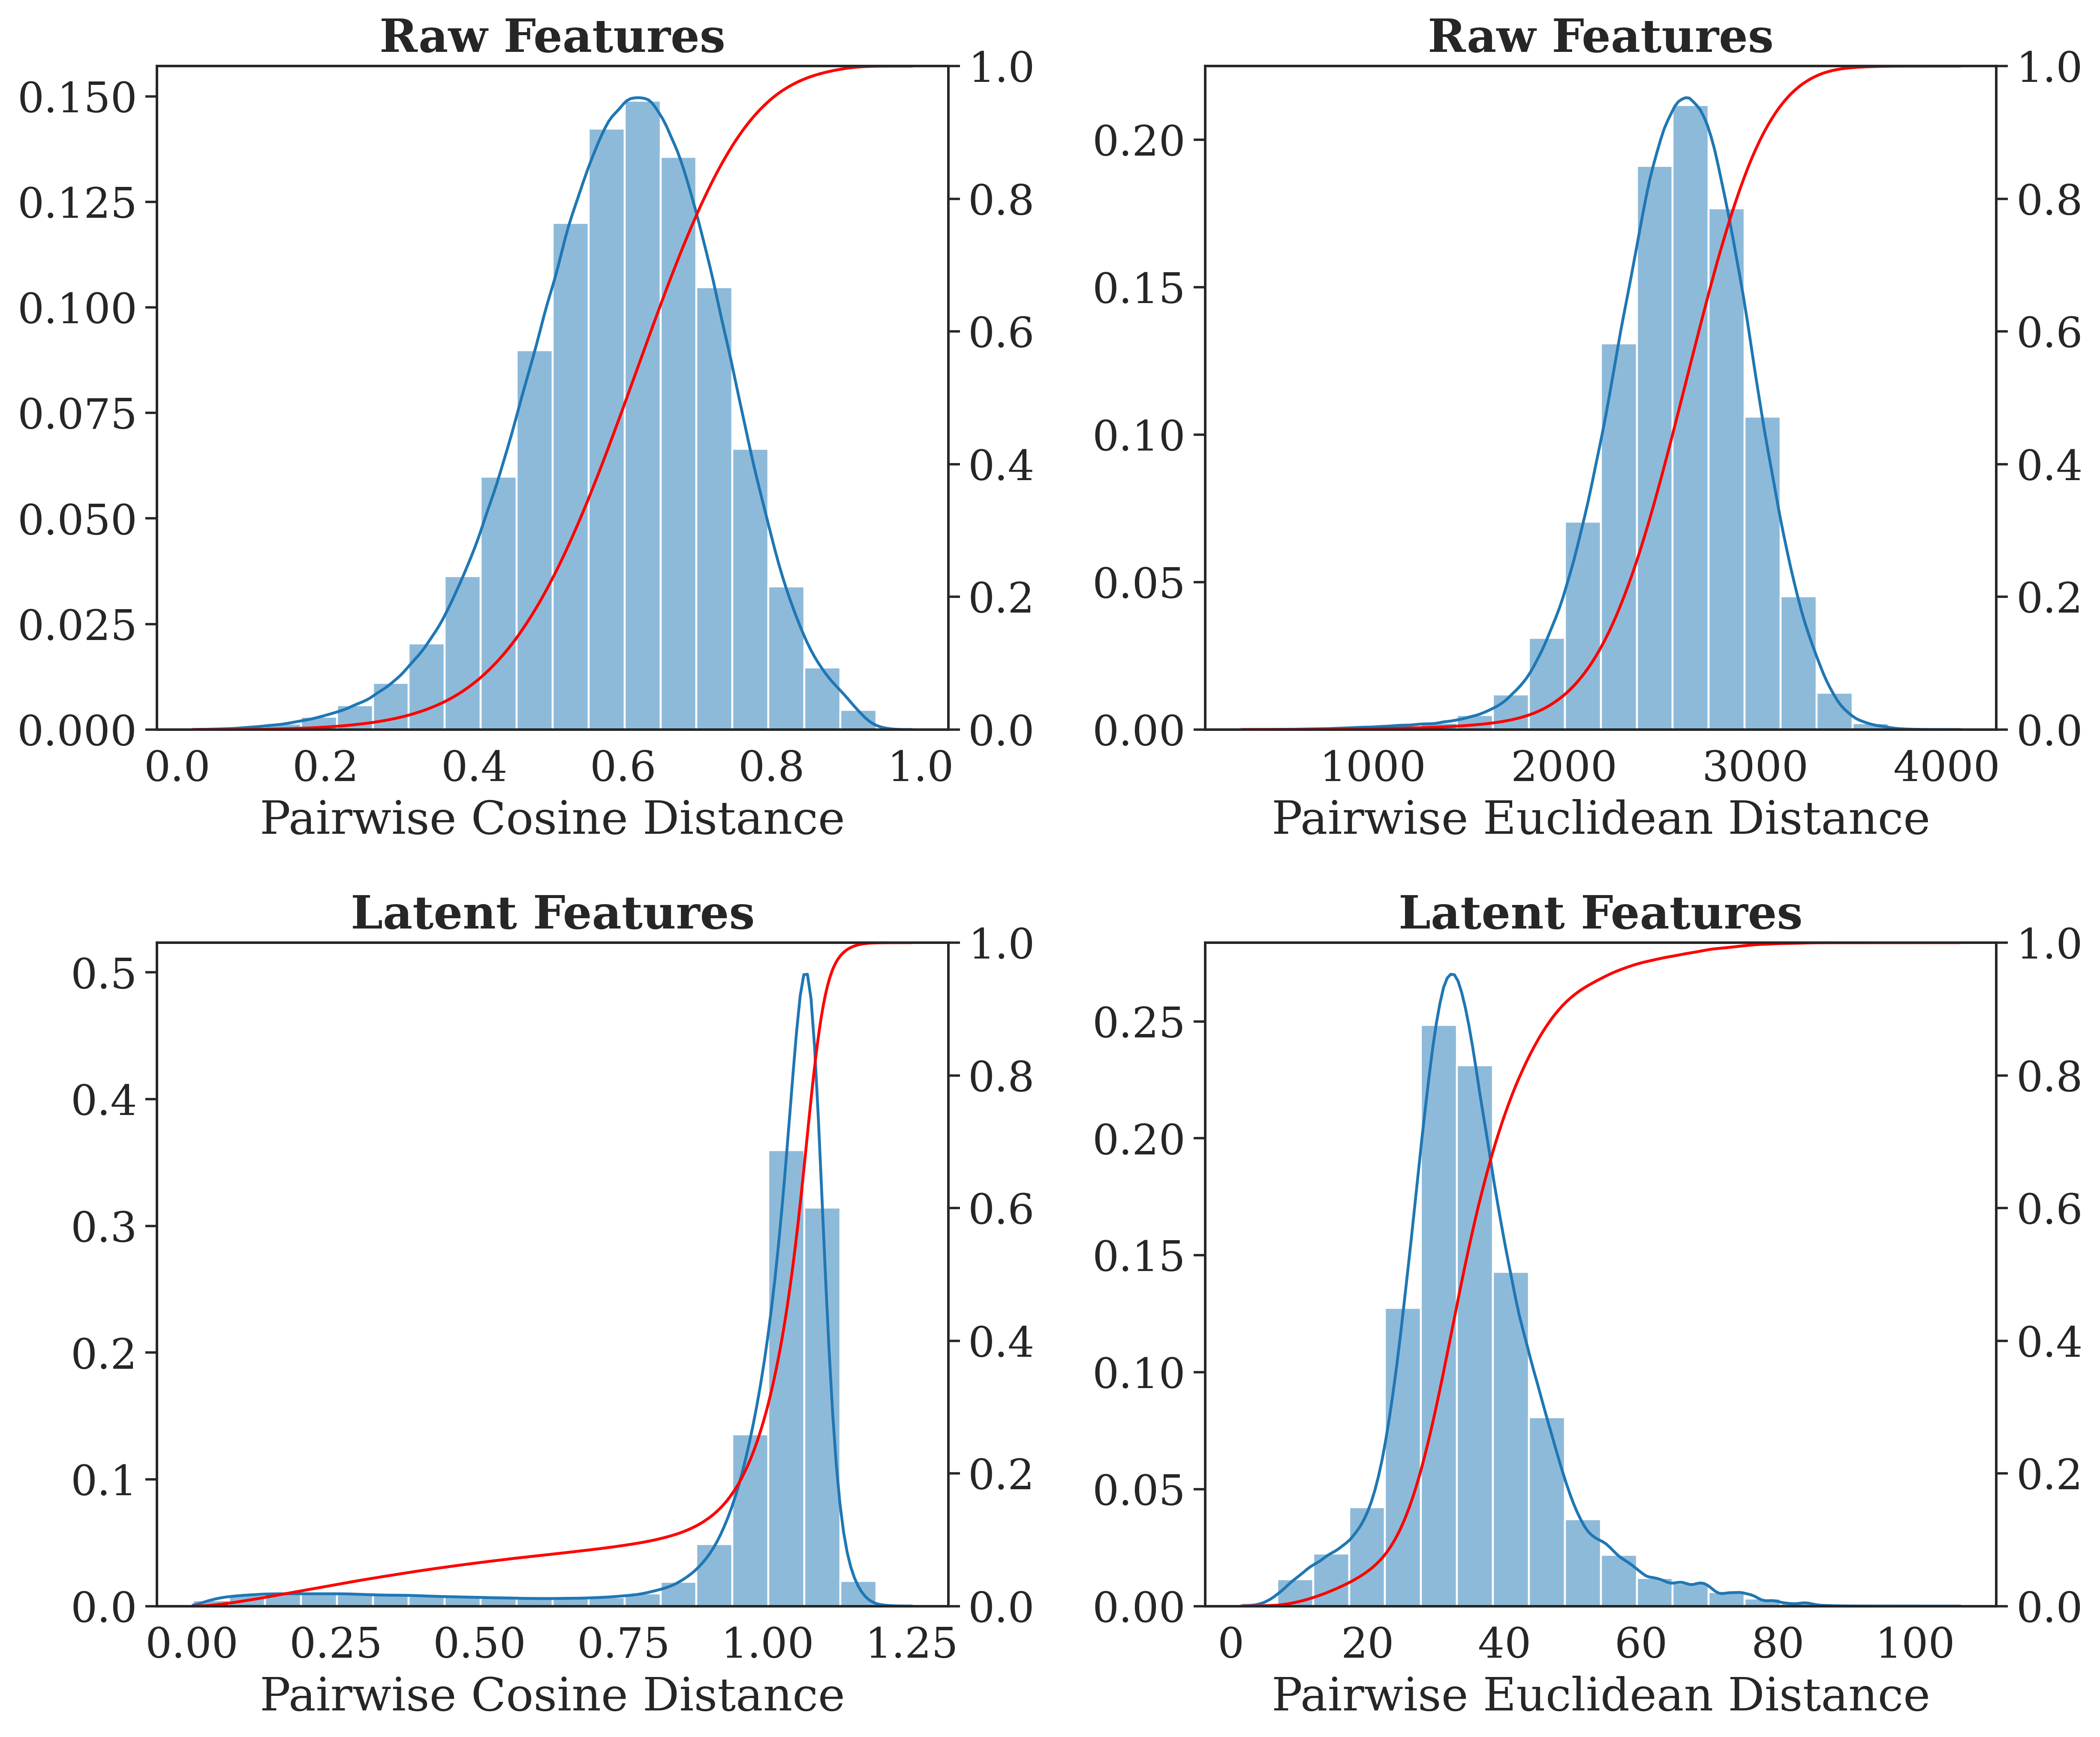

In [18]:
dist_matrices = [
    (raw_cos_mat, 'Pairwise Cosine Distance', 'Raw Features'),
    (raw_l2_mat, 'Pairwise Euclidean Distance', 'Raw Features'),
    (latent_cos_mat, 'Pairwise Cosine Distance', 'Latent Features'),
    (latent_l2_mat,'Pairwise Euclidean Distance', 'Latent Features'),
]

rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols)
fig.set_dpi(400)
fig.set_size_inches(12, 10)
fig.tight_layout(w_pad=3.0, h_pad=3.0)

for n, (dist_matrix, metric, dist) in enumerate(dist_matrices):

    ax = axes[n//cols][n%cols]

    dedup_dist = dist_matrix[np.triu_indices_from(dist_matrix, k=1)]
    # assert len(dedup_dist) == len(dist_matrix) * (len(dist_matrix)-1) / 2

    sns.histplot(x=dedup_dist, ax=ax, bins=20, kde=True, stat='proportion')
    ax.set_ylabel('')
    ax2 = ax.twinx()
    sns.ecdfplot(x=dedup_dist, stat='proportion', ax=ax2, c='r')
    ax2.set_ylabel('')
    ax2.set_title(dist, fontweight="bold")
    ax.set_xlabel(metric)
    # fig.legend(loc='upper left', bbox_to_anchor=(0.14, 0.86))

fig.savefig(os.path.join(FIG_PATH, 'pairwise_dist_plot.pdf'))

In [19]:
net_results = os.path.join(DATA_PATH, 'network_cv.csv')
net_df = pd.read_csv(net_results)
net_df.rename(columns={
    'features': 'Features',
    'dist_metric': 'Distance Metric',
    'accuracy': 'Accuracy',
    'std': 'Standard Deviation',
    'percentile': 'Percentile',
    'k': 'K'
}, inplace=True)
net_df['Type'] = np.where(net_df['K'].isna(), 'thres', 'knn')


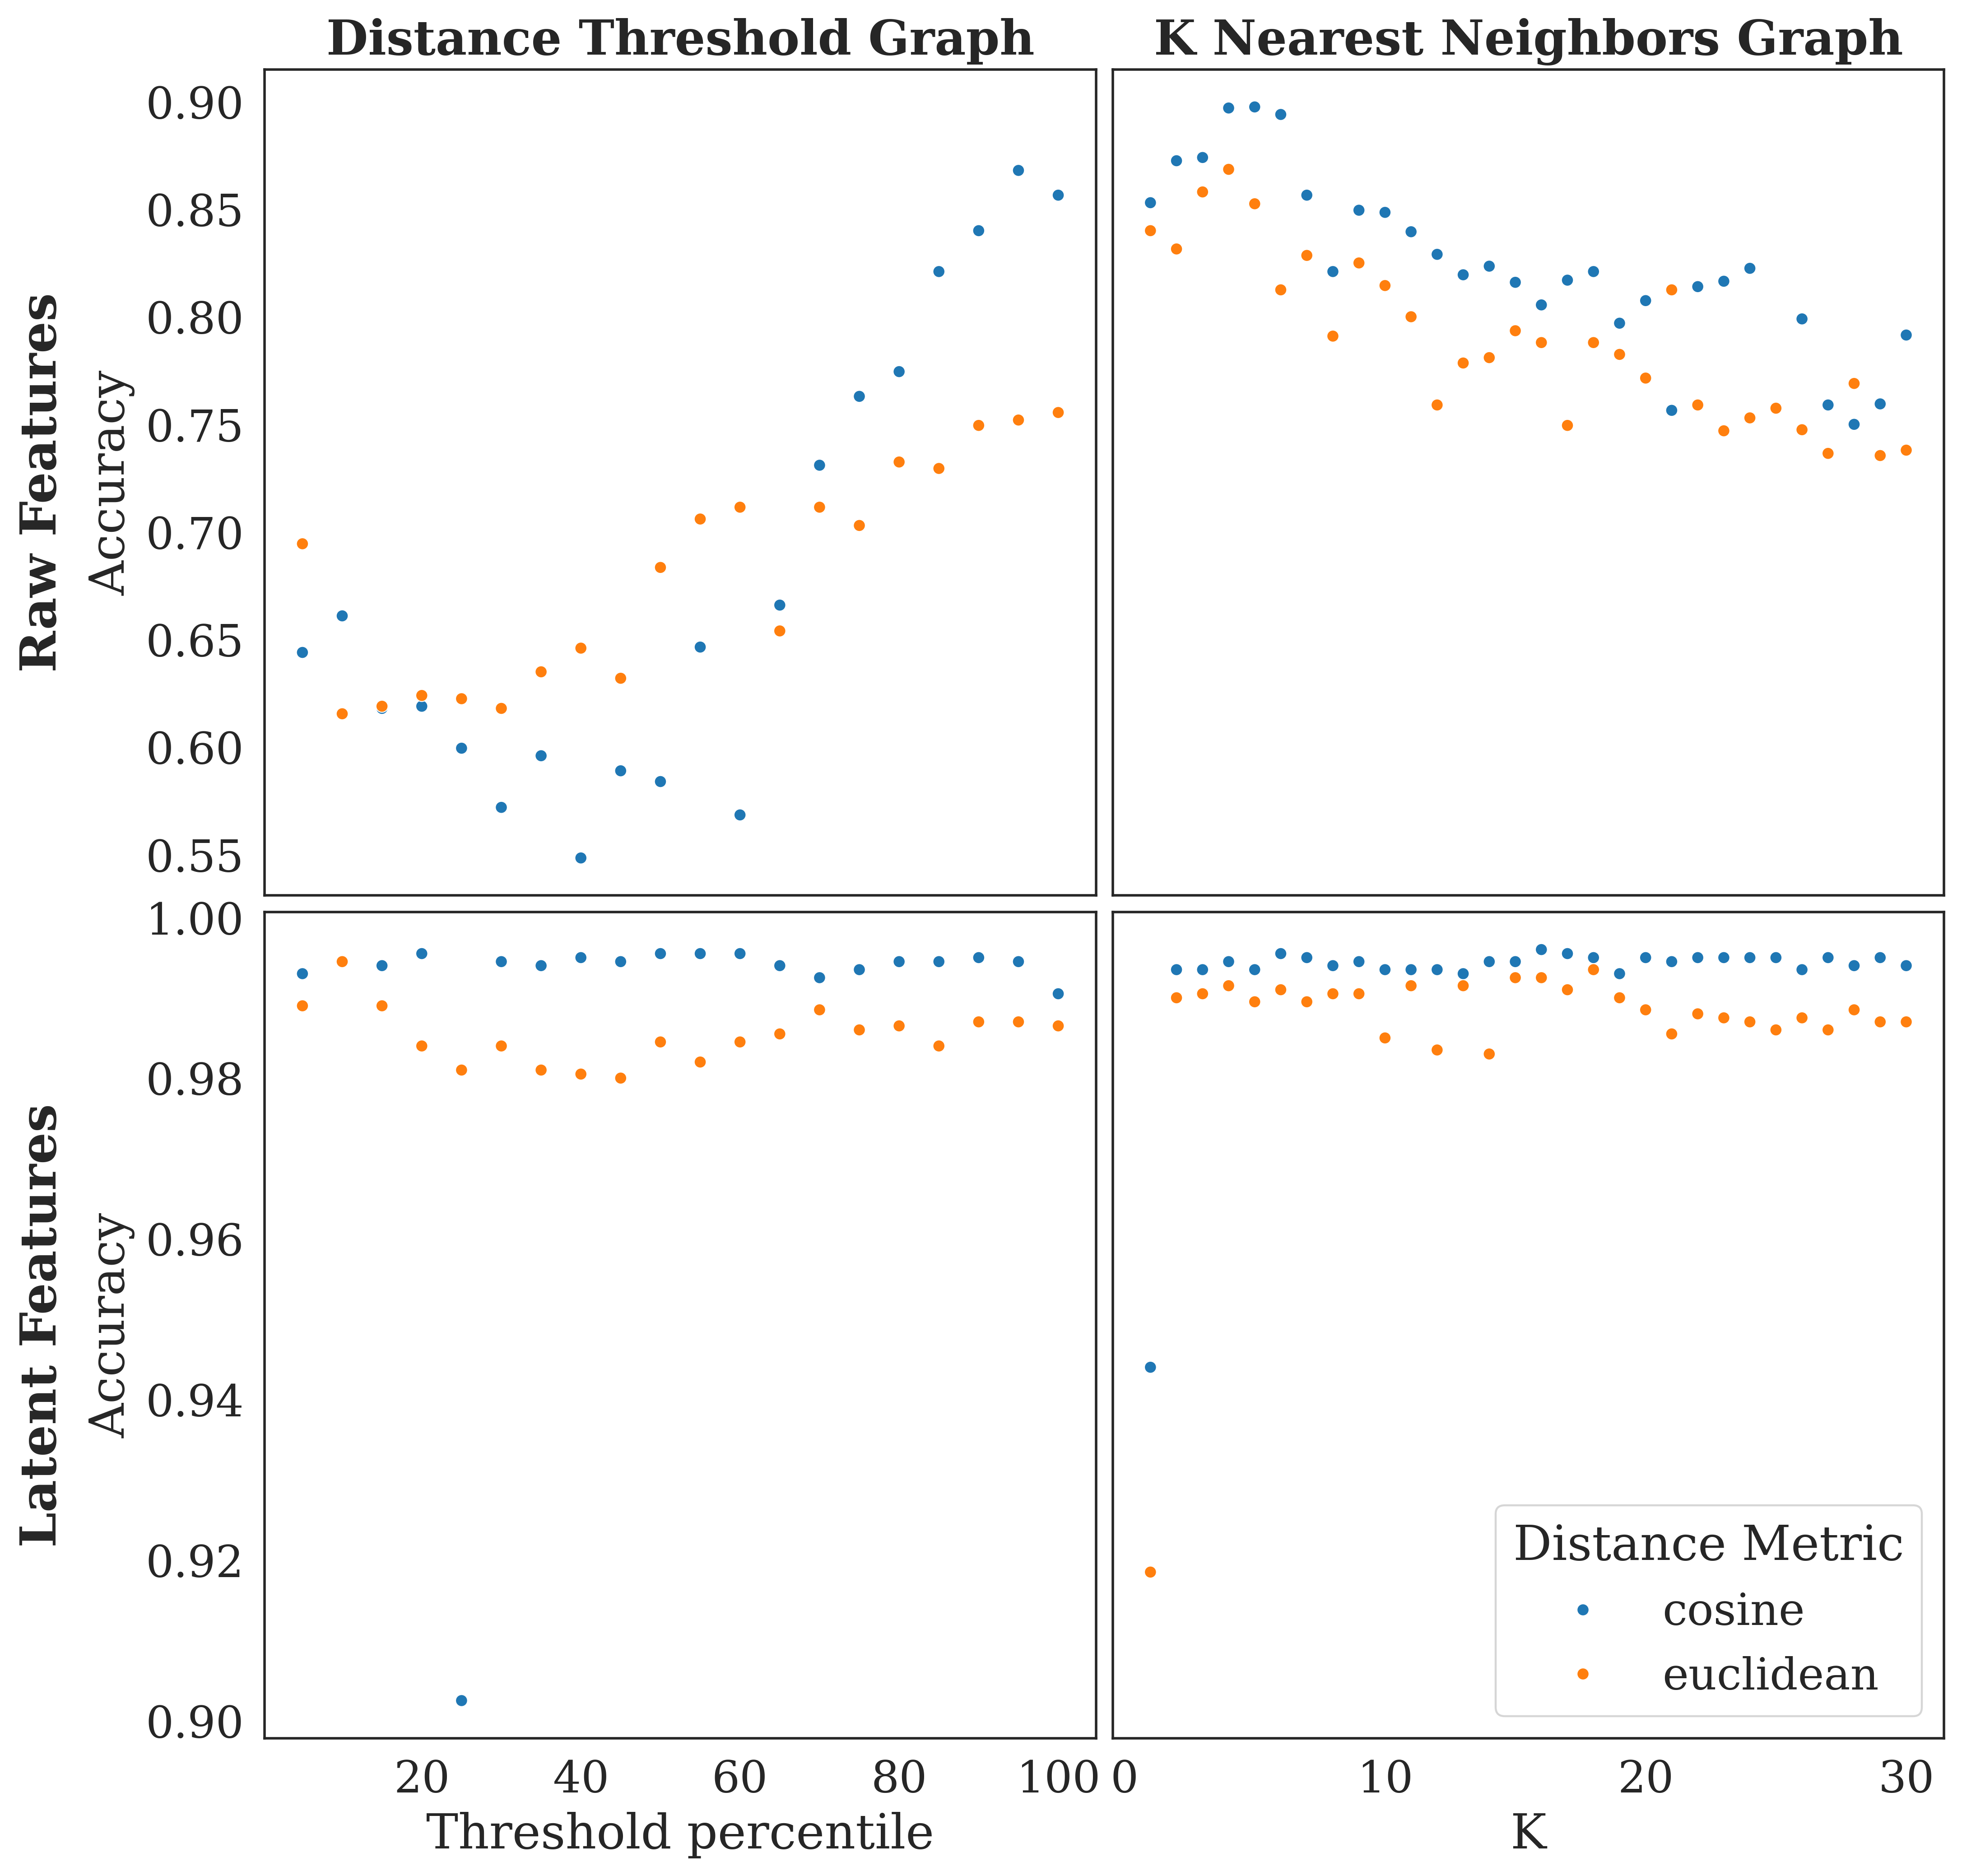

In [20]:
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row')
fig.set_dpi(400)
fig.set_size_inches(12, 12)
fig.subplots_adjust(wspace=0.02, hspace=0.02)

raw_df = net_df[net_df['Features']=='raw']
latent_df = net_df[net_df['Features']=='latent']

sns.scatterplot(raw_df, x='Percentile', y='Accuracy', hue='Distance Metric', ax=ax[0][0], legend=False)
ax[0][0].set_title('Distance Threshold Graph', fontweight='bold')

sns.scatterplot(raw_df, x='K', y='Accuracy', hue='Distance Metric', ax=ax[0][1], legend=False)
ax[0][1].set_title('K Nearest Neighbors Graph', fontweight='bold')

sns.scatterplot(latent_df, x='Percentile', y='Accuracy', hue='Distance Metric', ax=ax[1][0], legend=False)
ax[1][0].set_xlabel('Threshold percentile')

sns.scatterplot(latent_df, x='K', y='Accuracy', hue='Distance Metric', ax=ax[1][1])

ax[0][0].annotate('Raw Features', xy=(0, 0.5), xytext=(-ax[0][0].yaxis.labelpad-5, 0),
                  xycoords=ax[0][0].yaxis.label, textcoords='offset points',
                  size=20, ha='right', va='center', fontweight='bold', rotation='vertical')

ax[1][0].annotate('Latent Features', xy=(0, 0.5), xytext=(-ax[1][0].yaxis.labelpad-5, 0),
                  xycoords=ax[1][0].yaxis.label, textcoords='offset points',
                  size=20, ha='right', va='center', fontweight='bold', rotation='vertical')

fig.savefig(os.path.join(FIG_PATH, 'net_cv_plots.pdf'))

In [21]:
graph_params = net_df.to_dict('records')
best_raw_thres = graph_params[net_df[(net_df['Features']=='raw') & (net_df['Type']=='thres')]['Accuracy'].idxmax()]
best_raw_knn = graph_params[net_df[(net_df['Features']=='raw') & (net_df['Type']=='knn')]['Accuracy'].idxmax()]
best_latent_thres = graph_params[net_df[(net_df['Features']=='latent') & (net_df['Type']=='thres')]['Accuracy'].idxmax()]
best_latent_knn = graph_params[net_df[(net_df['Features']=='latent') & (net_df['Type']=='knn')]['Accuracy'].idxmax()]
print(best_raw_thres)
print(best_raw_knn)
print(best_latent_thres)
print(best_latent_knn)


{'algorithms': 'louvain', 'Features': 'raw', 'Distance Metric': 'cosine', 'Accuracy': 0.868, 'Standard Deviation': 0.0, 'Percentile': 95.0, 'K': nan, 'Type': 'thres'}
{'algorithms': 'louvain', 'Features': 'raw', 'Distance Metric': 'cosine', 'Accuracy': 0.8975000000000002, 'Standard Deviation': 0.0, 'Percentile': nan, 'K': 5.0, 'Type': 'knn'}
{'algorithms': 'louvain', 'Features': 'latent', 'Distance Metric': 'cosine', 'Accuracy': 0.9955, 'Standard Deviation': 0.0, 'Percentile': 20.0, 'K': nan, 'Type': 'thres'}
{'algorithms': 'louvain', 'Features': 'latent', 'Distance Metric': 'cosine', 'Accuracy': 0.996, 'Standard Deviation': 0.0, 'Percentile': nan, 'K': 16.0, 'Type': 'knn'}


In [22]:
def get_percentile(dist_matrix, percentile):
    distinct_dists = dist_matrix[np.triu_indices_from(dist_matrix, k=1)]
    return np.percentile(distinct_dists, percentile)

best_raw_thres_g = add_edges(base_graph(Y),
                             raw_cos_mat,
                             (0, get_percentile(raw_cos_mat, 95)))

best_raw_knn_g = add_knn_edges(base_graph(Y),
                               raw_cos_mat,
                               5)

best_latent_thres_g = add_edges(base_graph(Y),

                                latent_cos_mat,
                                (0, get_percentile(latent_cos_mat, 20)))

best_latent_knn_g = add_knn_edges(base_graph(Y),
                                  latent_cos_mat,
                                  16)

In [23]:
def graph_properties(graph):
    stat = {}
    stat['#nodes'] = graph.number_of_nodes()
    stat['#edges'] = graph.number_of_edges()
    degrees = np.array([d for _, d in graph.degree])
    stat['mean_degree'] = np.mean(degrees)
    stat['max_degree'] = np.max(degrees)
    stat['diameter'] = nx.diameter(graph)
    partitions = louvain_communities(graph, resolution=1.5)
    stat['#clusters'] = len(partitions)
    stat['modularity'] = nx.community.modularity(graph, partitions)
    return stat

graphs = [best_raw_thres_g, best_raw_knn_g, best_latent_thres_g, best_latent_knn_g]
properties = [graph_properties(graph) for graph in graphs]

In [24]:
print(pd.DataFrame(properties).to_string(index=False))

 #nodes  #edges  mean_degree  max_degree  diameter  #clusters  modularity
   2500 2967562    2374.0496        2499         2        143    0.027238
   2500    9456       7.5648          26        14         21    0.829063
   2500  624750     499.8000         944         3         11    0.688239
   2500   27850      22.2800          53        15         16    0.893717


In [25]:
train_idx = np.arange(N_TRAIN)
test_idx = np.arange(N_TRAIN, N_TRAIN+N_TEST)

for graph in graphs:
    partitions = louvain_communities(graph, resolution=1.5)
    pred_Y = assign_labels(partitions, train_idx, test_idx, Y)
    print(f'Test accuracy: {(pred_Y==test_Y.numpy()).mean()}')

Test accuracy: 0.844
Test accuracy: 0.866
Test accuracy: 0.982
Test accuracy: 0.98
